## 1. Packages

In [1]:
''' root '''
import os
os.chdir("/scratch/kll482/cathay")
print("Current Working Directory:", os.getcwd())

import sys
sys.path.append("/scratch/kll482/cathay/")

''' config '''
from configparser import ConfigParser
config = ConfigParser()
config.read("config/config.ini")
print("Config Sections:", config.sections())
args = config["graph_models"]

Current Working Directory: /scratch/kll482/cathay
Config Sections: ['text_cleaning', 'feature_engineering', 'graph_models']


In [2]:
# ''' packages '''
# import torch, torchvision
# import pandas as pd, numpy as np
# import argparse
# import torch
# import torch.nn.functional as F
# from torch import nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.utils.data import random_split
# # from torch_geometric.data.InMemoryDataset import collate
# from tqdm import tqdm_notebook as tqdm
# from sklearn.utils import shuffle
# from sklearn.metrics import confusion_matrix, classification_report
# from src.preprocessing.feature_engineering.bert_embedding import BertEmbedding
# import multiprocessing as mp

# import time
# from datetime import datetime
# import matplotlib.pyplot as plt
# import seaborn as sns

In [3]:
''' packages '''
# 1. models
import torch, torchvision
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# 2. others
from tqdm import tqdm_notebook as tqdm
import multiprocessing as mp
import argparse
import pandas as pd, numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
# from tensorboardX import SummaryWriter
# writer = SummaryWriter("logs/graph/")

# 3. custom
from src.preprocessing.feature_engineering.bert_embedding import BertEmbedding
from src.utils.vocabulary import Vocabulary
from src.utils.pipeline import Pipe

## 2.1. Initial Variables & Parameters

In [4]:
''' Hyperparameters '''
parser = {
    "batch_size": 64,
    "seed": 5, # random seed
    "epochs": 5,
    "cuda": True, # use cuda or not
    "log_every": 100,
    "lr": 0.01,  # initial learning rate
    "lr_decay": 0.7,  # decay lr when not observing improvement in val_loss
    "lr_min": 1e-5,  # stop when lr is too low
    "n_bad_loss": 4,  # number of bad val_loss before decaying
    "clip": 2.3,
    "result_path": "result/sequence/",  # path to save models
    "log_path": "logs/sequence/",
}
config = argparse.Namespace(**parser)

In [5]:
''' General '''
config.USE_CUDA = 1 # bool(int(args["use_cuda"]))
config.SEED = int(args["set_seed"])
config.MODELING_FEATURE_PATH = args["modeling_feature_path"]
config.DATA_PATH = args["data_path"]
config.NUM_FEATURES = 768
config.N_CLASSES = 1
config.TARGET = "overall"
config.TOKENS = "reviewTokens"

## 2.2. CUDA Settings

In [6]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config.USE_CUDA = config.USE_CUDA and torch.cuda.is_available()
print("cuda on: ", config.USE_CUDA)
if config.USE_CUDA:
    torch.cuda.manual_seed(config.SEED)
    torch.backends.cudnn.deterministic = True
else:
    torch.manual_seed(config.SEED)
    
device = torch.device("cuda:0" if config.USE_CUDA else "cpu")

cuda on:  True


In [7]:
def seed_torch(seed=config.SEED):
    #random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# 3-1. Data

In [8]:
print("read the datasets...")
files = []
# file_path = [file for file in os.listdir(config.DATA_PATH) if file.endswith(".json")]
# file_path = ['Video_Games_5.json', 'Musical_Instruments_5.json']
file_path = ['straight_Musical_Instruments_5.json']
config.dataset_used = "\t".join(file_path)

for file in file_path:    
    files.append(pd.read_json(os.path.join(config.DATA_PATH, file)))
    
df = pd.concat(files)

read the datasets...


In [9]:
print(df.shape)
df.head(3)

(230981, 5)


,overall,reviewText,reviewTokens,uniqueTokens,edgeIndex1
0,5,It's good for beginners,"[good, beginner]","[good, beginner]","[[0, 1], [1, 0]]"
1,5,I recommend this starter Ukulele kit. I has e...,"[recommend, starter, ukulele, kit, everything,...","[learn, kit, starter, recommend, ukulele, ever...","[[3, 2, 2, 4, 4, 1, 1, 5, 5, 6, 6, 0, 0, 4], [..."
2,5,G'daughter received this for Christmas present...,"[g, daughter, receive, christmas, present, las...","[receive, year, play, daughter, g, present, la...","[[4, 3, 3, 0, 0, 7, 7, 5, 5, 6, 6, 1, 1, 2, 2,..."


Let's take a look at the length of review tokens.

In [10]:
review_len = [len(row) for row in df["reviewTokens"]]
print("max:", max(review_len))
print("min:", min(review_len))
print("median:", np.median(review_len))
print("mean:", np.mean(review_len))
print("Q3:", np.quantile(review_len, 0.75))
print("Q1:", np.quantile(review_len, 0.25))
print("Q(90%):", np.quantile(review_len, 0.9))

max: 2191
min: 1
median: 14.0
mean: 29.245665227875886
Q3: 32.0
Q1: 5.0
Q(90%): 69.0


<AxesSubplot:>

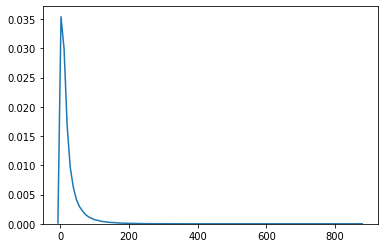

In [11]:
word_len = [len(row) for row in df["uniqueTokens"]]
sns.distplot(word_len, hist=False)

## 3-2. Review Score to Positive/Negative

In [12]:
def reclassify(df, target="overall"):
    '''
    1. score 3 & 4 & 5 -> 1 (positive)
    2. score 1 & 2 -> 0 (negative)
    '''
    y = []
    for gp in df[target]:
        if gp in [3, 4, 5]:
            y.append(1)
        elif gp in [1, 2]:
            y.append(0)
    assert len(y) == df.shape[0]
    
    return y

In [13]:
df["y"] = reclassify(df, "overall")
config.TARGET = "y"

## 3-3. Train Test Split

In [14]:
def dataset_split(df, train_percent=0.8, val_percent=0.1, set_seed=config.SEED):
    n = df.shape[0] # get length of dataframe

    # I will set the percentage of validation and test sets to be both 0.1
    train_index, rest_index = train_test_split(range(n), train_size=0.8, random_state=config.SEED)
    val_index, test_index = train_test_split(rest_index, train_size=(val_percent/(1-train_percent)), random_state=config.SEED) # 0.1/(1-0.8) = 0.1/0.2 = 0.5

    # check if there is any intersection among all three sets
    assert len(set(train_index + val_index + test_index)) == n

    # get sub_datasets by random_split
    np.random.seed(config.SEED)
    train_df, val_df, test_df = df.iloc[train_index, :].reset_index(drop=True),\
                                df.iloc[val_index, :].reset_index(drop=True),\
                                df.iloc[test_index, :].reset_index(drop=True)

    # check random_split works correctly
    assert (len(train_df)+len(val_df)+len(test_df)) == n
    
    return train_df, val_df, test_df

In [15]:
train_df, val_df, test_df = dataset_split(df)

## 3-4. Build Vocabulary

It's reasonable to build a vocabulary list from only the training set.

In [16]:
vocabulary = Vocabulary()

for row in train_df[config.TOKENS]:
    for word in row:
        vocabulary.add_word(word)

## 3-5. Imbalanced Dataset

Note: I only make the training set balanced and leave the validation and test sets alone.

<AxesSubplot:xlabel='y', ylabel='count'>

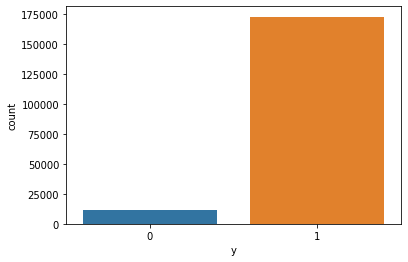

In [17]:
# plot the imbalanced target variable
sns.countplot(train_df[config.TARGET])

In [18]:
# undersampling
def undersampling(df, target=config.TARGET, set_seed=config.SEED):
    np.random.seed(set_seed)
    df = df.groupby(target)
    df = df.apply(lambda x: x.sample(df.size().min())).sample(frac=1).reset_index(drop=True)
    return df

In [19]:
train_df = undersampling(train_df)
print("Length of training set:", train_df.shape[0])
print("Length of test set:", test_df.shape[0])

Length of training set: 23638
Length of test set: 23099


## 4-1. Dataset

In [20]:
# https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html
class ReviewDataset(Dataset):
    def __init__(self, config, df, use_cuda, embeddings):
        self.df = df
        self.use_cuda = use_cuda
        self.embeddings = embeddings
        self.config = config
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        tt = torch.cuda if self.use_cuda else torch
        x = tt.FloatTensor(self.embeddings.get_embeddings(self.df[self.config.TOKENS][idx]))
#         x = tt.FloatTensor(self.df[self.config.TOKENS][idx])
        y = tt.FloatTensor([self.df[self.config.TARGET][idx]])
        return x, y

In [21]:
train_dataset = ReviewDataset(config,
                       df=train_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=134),
                       )
val_dataset = ReviewDataset(config,
                       df=val_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=134),
                       )
test_dataset = ReviewDataset(config,
                       df=test_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=134),
                       )

In [22]:
# check if the row length remains the same even we transform dataframe into graph dataset
assert len(train_dataset)+len(val_dataset)+len(test_dataset) == len(train_df)+len(val_df)+len(test_df)

## 4-2. DataLoader

In [23]:
# ''' For InMemoryDataset '''
# def get_dataloaders(config, dataset, train_percent=0.8, val_percent=0.1):
    
#     # get length of subsets
#     train_len = int(dataset.__len__()*0.8)
#     val_len = int(dataset.__len__()*0.1)
#     test_len = dataset.__len__()-train_len-val_len
    
#     # get sub_datasets by random_split
#     seed_torch(config.SEED)
#     train_dataset, val_dataset, test_dataset = random_split(dataset, (train_len, val_len, test_len))
    
#     # check random_split works correctly
#     assert (len(train_dataset)+len(val_dataset)+len(test_dataset)) == dataset.__len__()
    
#     # get dataloaders
#     train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
#     test_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    
#     return train_loader, val_loader, test_loader

# train_loader, val_loader, test_loader = get_dataloaders(config, dataset, train_percent=0.8, val_percent=0.1)

In [24]:
seed_torch(config.SEED)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

## 5. Architecture

In [25]:
# https://www.kaggle.com/ziliwang/baseline-pytorch-bilstm
class MultiClassBiLSTM(nn.Module):
    def __init__(self, embedding_dim, n_classes=1, rnn_layer=2, dropout=0.3):
        super(MultiClassBiLSTM, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=embedding_dim,
                            num_layers=lstm_layer, 
                            dropout = dropout,
                            bidirectional=True)
        self.relu = nn.ReLU()
        self.classify = nn.Linear(embedding_dim*2, n_classes)
    
    def forward(self, x):
#         x = torch.transpose(x, dim0=1, dim1=0)
        out, (h_n, c_n) = self.lstm(x) # out: batch, num_seq, 2*hidden
        out = self.relu(out)
        print(out.size())
        out = self.classify(out)
        
        return F.log_softmax(out, dim=1)

In [26]:
# https://www.kaggle.com/ziliwang/baseline-pytorch-bilstm
class BinaryBiLSTM(nn.Module):
    def __init__(self, embedding_dim, n_classes=1, rnn_layer=2, dropout=0.3, hidden_transfer="last"):
        super(BinaryBiLSTM, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=embedding_dim,
                            num_layers=lstm_layer, 
                            dropout = dropout,
                            bidirectional=True)
        self.relu = nn.ReLU()
        self.classify = nn.Linear(embedding_dim*2, n_classes)
        
        assert hidden_transfer in ["mean", "last"]
        self.hidden_transfer = hidden_transfer

    def forward(self, x):
        x = torch.transpose(x, dim0=1, dim1=0) # x: batch x seq_len x embedding_dim -> seq_len x batch x embedding_dim
        out, (h_n, c_n) = self.lstm(x) # out: seq_len x batch x 2*embedding_dim
        if self.hidden_transfer == "mean":
            out = torch.mean(out, dim=0)
        elif self.hidden_transfer == "last":
            out = out[-1] # out: batch x 2*embedding_dim
        out = self.relu(out) # out: batch x 2*embedding_dim
        out = self.classify(out) # out: batch x n_classes
        return out

In [38]:
# https://www.kaggle.com/ziliwang/baseline-pytorch-bilstm
class BinaryRNN(nn.Module):
    def __init__(self, embedding_dim, n_classes=1, rnn_layer=2, dropout=0, hidden_transfer="last"):
        super(BinaryRNN, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.lstm = nn.RNN(input_size=embedding_dim,
                            hidden_size=128,
                            num_layers=rnn_layer, 
                            dropout = dropout,
                            bidirectional=False)
        self.relu = nn.ReLU()
        self.classify = nn.Linear(128, n_classes)
        
        assert hidden_transfer in ["mean", "last"]
        self.hidden_transfer = hidden_transfer

    def forward(self, x):
        x = torch.transpose(x, dim0=1, dim1=0) # x: batch x seq_len x embedding_dim -> seq_len x batch x embedding_dim
        out, (h_n, c_n) = self.lstm(x) # out: seq_len x batch x 2*embedding_dim
        if self.hidden_transfer == "mean":
            out = torch.mean(out, dim=0)
        elif self.hidden_transfer == "last":
            out = out[-1] # out: batch x 2*embedding_dim
        out = self.relu(out) # out: batch x 2*embedding_dim
        out = self.classify(out) # out: batch x n_classes
        return out

## 6. Train & Validation & Test Functions

In [28]:
def adjust_learning_rate(optimizer, lr_decay):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay

In [29]:
def write_log(text, file_path, mode="a+"):
    print(text)
    with open(file_path, mode) as file:
        file.write(text+"\n")

In [30]:
def write_config(config):
    texts = "=== Settings ===\n"
    var_config = vars(config)
    for i in range(len(var_config)):
        temp_text = "{}: {}\n".format(list(var_config.keys())[i],
                                      list(var_config.values())[i],
                                     )
        texts += temp_text
    texts += "============\n\n"
    return texts

In [31]:
def train(config, train_loader, val_loader, model, criterion, optimizer):
    global iteration, n_total, train_loss, n_bad_loss
    global init, best_val_loss, stop

    logs = "=> EPOCH {}".format(epoch)
    write_log(logs, config.log_file, "a+")
    
    for batch_index, batch in tqdm(enumerate(train_loader)):
        iteration += 1 # total iteration within all batches
        batch_size = batch[0].size()[0]
        
        if config.N_CLASSES == 1:
            # binary
            label = batch[1].float()
        elif config.N_CLASSES > 1:
            label = batch[1].long()
        label = label.to(device).detach()
        
        # train the model
        model.train()
#         for param in model.parameters():
#             print(param.requires_grad)
        output = model(batch[0])
        
        # loss function
        loss = criterion(output, label)
        
        # BP
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip, 'inf')
        optimizer.step()
        
        # sum with the previous training loss for updating learning rate in the following
        train_loss += batch_size * loss.item() # accumulated training loss; batch.num_graphs is the size of the batch
        n_total += batch_size
        
#         # validation check
        if iteration % config.log_every == 0:
            train_loss /= n_total 
            val_loss = validate(config, val_loader, model, criterion)
        
            # save logs
            logs = "   % Time: {} | Iteration: {:5} | Batch: {:4}/{}"\
                  " | Train loss: {:.4f} | Val loss: {:.4f}"\
                  .format(str(datetime.now()-init), iteration, batch_index+1,
                          len(train_loader), train_loss, val_loss)
            write_log(logs, config.log_file, "a+")

            # test for val_loss improvement
            n_total = train_loss = 0
            if val_loss < best_val_loss: # update the best validation loss
                best_val_loss = val_loss
                n_bad_loss = 0
                torch.save(model.state_dict(), config.best_model) # save the checkpoint
            else:
                n_bad_loss += 1
            
            # update the learning rate if val loss does not improve for n_bad_loss times
            if n_bad_loss == config.n_bad_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                adjust_learning_rate(optimizer, config.lr_decay)
                new_lr = optimizer.param_groups[0]['lr']
                
                logs = "=> Adjust learning rate to: {}".format(new_lr)
                write_log(logs, config.log_file, "a+")
                
                if new_lr < config.lr_min:
                    stop = True
                    break

In [32]:
def validate(config, val_loader, model, criterion):
#     for param in model.parameters():
#         param.requires_grad = False
        
    model.eval()
    val_loss = 0
    dataset_size = 0
    for batch in val_loader:
        batch_size = batch[0].size()[0]
        
        if config.N_CLASSES == 1:
            # binary
            label = batch[1].float()
        elif config.N_CLASSES > 1:
            label = batch[1].long()
        label = label.to(device).detach()
        dataset_size += batch_size
        
        # train the model
        output = model(batch[0])
        loss = criterion(output, label)
        val_loss += loss.data * batch_size
    return val_loss / dataset_size

In [33]:
def test(config, test_loader, model, threshold=0.5):
    print("start testing...")
#     for param in model.parameters():
#         param.requires_grad = False
        
    model.eval()
    dataset_size = 0
    label_list = []
    prediction_list = []
    predict_prob_list = []
    
    for batch in tqdm(test_loader):
        
        if config.N_CLASSES > 1:
            label = batch[1].float()            
            label = label.data.tolist()
            label_list += label
            output = model(batch)
            _, prediction = torch.max(output, 1)
            prediction = prediction.data.tolist()
            prediction_list += prediction
            
        elif config.N_CLASSES == 1:
            # binary
            label = batch[1].float()            
            label = label.data.tolist()
            label_list += label
            
            output = model(batch[0]).squeeze(-1)
            sigmoid = nn.Sigmoid() 
            output = sigmoid(output) # [-inf, inf] -> [0, 1]
            prediction_list += [1 if o > threshold else 0 for o in output.data.tolist()]
            predict_prob_list += output.data.tolist()
        
    confusion_matrix_df = pd.DataFrame(confusion_matrix(label_list, prediction_list))#.rename(columns=["1","2","3","4","5"], index=["1","2","3","4","5"])
    # write the confusion matrix into the log
    write_log("\n{}\n\n{}\n".\
          format("=== Confusion Matrix ===",
                 confusion_matrix_df
                 
                ),
          config.log_file,
          "a+")
    
    sns.heatmap(confusion_matrix_df, annot=True)
    
    return label_list, prediction_list, predict_prob_list

In [34]:
def model_load(config, model_test, name):
    if name is None:
        model_reloaded = config.best_model
    else:
        model_reloaded = os.path.join(config.result_path, "checkpoint/{}.pth".format(name))
    model_train = torch.load(model_reloaded)
#     model_test = BinGATConv(config.NUM_FEATURES, config.N_CLASSES).to(device)
    model_test.load_state_dict(model_train)

    return model_test

## 7. Training

In [ ]:
''' initials '''
# seed_torch(config.SEED)
seed_torch(config.SEED)
config.N_CLASSES = 1
model_name = "RNN"
config.batch_size = 32
config.lr = 0.001

''' rebuild dataset and dataloader due to edge_index '''
train_dataset = ReviewDataset(config,
                       df=train_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=134),
                       )
val_dataset = ReviewDataset(config,
                       df=val_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=134),
                       )
test_dataset = ReviewDataset(config,
                       df=test_df,
                       use_cuda=config.USE_CUDA,
                       embeddings=BertEmbedding(max_len=134),
                       )

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

''' initializing the model '''
if config.N_CLASSES == 1:
    # binary
    model = BinaryRNN(config.NUM_FEATURES, config.N_CLASSES).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
else:
    # MultiClass
    model = MultiClassBiLSTM(embedding_dim=config.NUM_FEATURES,
                             n_classes=config.N_CLASSES,
                             dropout=0).to(device)
    criterion = nn.NLLLoss().to(device)

optimizer = optim.Adagrad(model.parameters(), lr=config.lr)

config.best_model = os.path.join(config.result_path, "checkpoint/{}_{}.pth".format(model_name,
                                                                                   datetime.now().strftime("%Y_%m_%d_%H_%M")
                                                                                  )
                                )
config.log_file = os.path.join(config.log_path, "{}_{}.txt".format(model_name,
                                                                              datetime.now().strftime("%Y_%m_%d_%H_%M")
                                                                            )
                              )
''' start training '''
saved = True
if 1 == 1:  # change to True to train
    iteration = n_total = train_loss = n_bad_loss = 0
    stop = False
    best_val_loss = float("inf")
    init = datetime.now()
    config.epochs = 15
    config.log_every = 200
    config.n_bad_loss = 4

    if saved:
        output_text = write_config(config) + "Start record at {}\n".format(str(datetime.now()))
        write_log(output_text,
                  config.log_file,
                  "w+")
        
    for epoch in range(1, config.epochs+1):
        train(config, train_loader, val_loader, model, criterion, optimizer)
        if stop:
            break

=== Settings ===
batch_size: 32
seed: 5
epochs: 15
cuda: True
log_every: 200
lr: 0.001
lr_decay: 0.7
lr_min: 1e-05
n_bad_loss: 4
clip: 2.3
result_path: result/sequence/
log_path: logs/sequence/
USE_CUDA: True
SEED: 123
MODELING_FEATURE_PATH: dataset/full_dataset/modeling_features.json
DATA_PATH: dataset/processed_dataset/
NUM_FEATURES: 768
N_CLASSES: 1
TARGET: y
TOKENS: reviewTokens
dataset_used: straight_Musical_Instruments_5.json
best_model: result/sequence/checkpoint/RNN_2020_08_25_05_19.pth
log_file: logs/sequence/RNN_2020_08_25_05_19.txt

Start record at 2020-08-25 05:19:32.561824

=> EPOCH 1


/scratch/kll482/anaconda3/envs/cathay/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


   % Time: 0:05:13.886468 | Iteration:   200 | Batch:  200/739 | Train loss: 0.6937 | Val loss: 0.6930
   % Time: 0:10:26.345067 | Iteration:   400 | Batch:  400/739 | Train loss: 0.6931 | Val loss: 0.6871
   % Time: 0:15:37.637055 | Iteration:   600 | Batch:  600/739 | Train loss: 0.6933 | Val loss: 0.7004

=> EPOCH 2


   % Time: 0:20:49.788654 | Iteration:   800 | Batch:   61/739 | Train loss: 0.6928 | Val loss: 0.6732
   % Time: 0:26:00.752848 | Iteration:  1000 | Batch:  261/739 | Train loss: 0.6933 | Val loss: 0.6953
   % Time: 0:31:11.674491 | Iteration:  1200 | Batch:  461/739 | Train loss: 0.6927 | Val loss: 0.6959


In [34]:
# seed_torch(config.SEED)
# config.N_CLASSES = 1

# if config.N_CLASSES == 1:
#     # binary
#     model = BinaryBiLSTM(config.NUM_FEATURES, config.N_CLASSES).to(device)
#     criterion = nn.BCEWithLogitsLoss().to(device)
# else:
#     # MultiClass
#     model = MultiClassBiLSTM(embedding_dim=config.NUM_FEATURES,
#                              n_classes=config.N_CLASSES,
#                              dropout=0).to(device)
#     criterion = nn.NLLLoss().to(device)
    
# optimizer = optim.Adagrad(model.parameters(), lr=config.lr)

# config.best_model = os.path.join(config.result_path, "checkpoint/neighbor{}_{}_{}.pth".format(3,
#                                                                                              "LSTM",
#                                                                                              datetime.now().strftime("%Y_%m_%d_%H_%M")
#                                                                                             )
#                                 )
# config.log_file = os.path.join(config.log_path, "neighbor{}_{}_{}.txt".format(3,
#                                                                               "LSTM",
#                                                                               datetime.now().strftime("%Y_%m_%d_%H_%M")
#                                                                                )
#                               )

In [35]:
# saved = True
# if 1 == 1:  # change to True to train
#     iteration = n_total = train_loss = n_bad_loss = 0
#     stop = False
#     best_val_loss = float("inf")
#     init = datetime.now()
#     config.epochs = 10
# #     config.n_bad_loss 4
#     if saved:
#         write_log("Start record at {}\n".format(str(datetime.now())),
#                   config.log_file,
#                   "w+")
#     for epoch in range(1, config.epochs+1):
#         train(config, train_loader, val_loader, model, criterion, optimizer)
#         if stop:
#             break

=> EPOCH 1


/scratch/kll482/anaconda3/envs/cathay/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


   % Time: 0:01:46.178220 | Iteration:   100 | Batch:  100/667 | Train loss: 0.7400 | Val loss: 0.6931
   % Time: 0:03:29.330737 | Iteration:   200 | Batch:  200/667 | Train loss: 0.6942 | Val loss: 0.6950
   % Time: 0:05:12.249364 | Iteration:   300 | Batch:  300/667 | Train loss: 0.6939 | Val loss: 0.6931
   % Time: 0:06:55.106757 | Iteration:   400 | Batch:  400/667 | Train loss: 0.6938 | Val loss: 0.6932
   % Time: 0:08:37.712439 | Iteration:   500 | Batch:  500/667 | Train loss: 0.6938 | Val loss: 0.6944
   % Time: 0:10:20.419047 | Iteration:   600 | Batch:  600/667 | Train loss: 0.6936 | Val loss: 0.6930

=> EPOCH 2


   % Time: 0:12:03.191009 | Iteration:   700 | Batch:   33/667 | Train loss: 0.6935 | Val loss: 0.6929
   % Time: 0:13:46.022992 | Iteration:   800 | Batch:  133/667 | Train loss: 0.6932 | Val loss: 0.6945
   % Time: 0:15:28.779864 | Iteration:   900 | Batch:  233/667 | Train loss: 0.6936 | Val loss: 0.6940
   % Time: 0:17:11.843233 | Iteration:  1000 | Batch:  333/667 | Train loss: 0.6932 | Val loss: 0.6928
   % Time: 0:18:54.798077 | Iteration:  1100 | Batch:  433/667 | Train loss: 0.6932 | Val loss: 0.6928
   % Time: 0:20:37.708624 | Iteration:  1200 | Batch:  533/667 | Train loss: 0.6931 | Val loss: 0.6925
   % Time: 0:22:20.965800 | Iteration:  1300 | Batch:  633/667 | Train loss: 0.6931 | Val loss: 0.6930

=> EPOCH 3


   % Time: 0:24:03.325921 | Iteration:  1400 | Batch:   66/667 | Train loss: 0.6933 | Val loss: 0.6925
   % Time: 0:25:46.083991 | Iteration:  1500 | Batch:  166/667 | Train loss: 0.6928 | Val loss: 0.6926
   % Time: 0:27:28.930592 | Iteration:  1600 | Batch:  266/667 | Train loss: 0.6933 | Val loss: 0.6924
   % Time: 0:29:12.092595 | Iteration:  1700 | Batch:  366/667 | Train loss: 0.6929 | Val loss: 0.6920
   % Time: 0:30:54.998296 | Iteration:  1800 | Batch:  466/667 | Train loss: 0.6929 | Val loss: 0.6927
   % Time: 0:32:37.740151 | Iteration:  1900 | Batch:  566/667 | Train loss: 0.6920 | Val loss: 0.6929
   % Time: 0:34:20.795365 | Iteration:  2000 | Batch:  666/667 | Train loss: 0.6926 | Val loss: 0.6918

=> EPOCH 4


   % Time: 0:36:03.499585 | Iteration:  2100 | Batch:   99/667 | Train loss: 0.6932 | Val loss: 0.6923
   % Time: 0:37:46.510389 | Iteration:  2200 | Batch:  199/667 | Train loss: 0.6927 | Val loss: 0.6942
   % Time: 0:39:29.271913 | Iteration:  2300 | Batch:  299/667 | Train loss: 0.6926 | Val loss: 0.6916
   % Time: 0:41:12.422652 | Iteration:  2400 | Batch:  399/667 | Train loss: 0.6917 | Val loss: 0.6916
   % Time: 0:42:55.318922 | Iteration:  2500 | Batch:  499/667 | Train loss: 0.6925 | Val loss: 0.6914
   % Time: 0:44:38.159164 | Iteration:  2600 | Batch:  599/667 | Train loss: 0.6925 | Val loss: 0.6919

=> EPOCH 5


   % Time: 0:46:20.764817 | Iteration:  2700 | Batch:   32/667 | Train loss: 0.6918 | Val loss: 0.6915
   % Time: 0:48:03.926512 | Iteration:  2800 | Batch:  132/667 | Train loss: 0.6918 | Val loss: 0.6919
   % Time: 0:49:46.724723 | Iteration:  2900 | Batch:  232/667 | Train loss: 0.6924 | Val loss: 0.6915
   % Time: 0:51:29.475810 | Iteration:  3000 | Batch:  332/667 | Train loss: 0.6918 | Val loss: 0.6916
   % Time: 0:53:12.400121 | Iteration:  3100 | Batch:  432/667 | Train loss: 0.6931 | Val loss: 0.6916
   % Time: 0:54:55.354984 | Iteration:  3200 | Batch:  532/667 | Train loss: 0.6921 | Val loss: 0.6913
   % Time: 0:56:39.002330 | Iteration:  3300 | Batch:  632/667 | Train loss: 0.6928 | Val loss: 0.6916

=> EPOCH 6


   % Time: 0:58:21.822922 | Iteration:  3400 | Batch:   65/667 | Train loss: 0.6919 | Val loss: 0.6917
   % Time: 1:00:04.773279 | Iteration:  3500 | Batch:  165/667 | Train loss: 0.6921 | Val loss: 0.6914
   % Time: 1:01:47.408068 | Iteration:  3600 | Batch:  265/667 | Train loss: 0.6918 | Val loss: 0.6913
   % Time: 1:03:30.645946 | Iteration:  3700 | Batch:  365/667 | Train loss: 0.6919 | Val loss: 0.6915
   % Time: 1:05:14.800460 | Iteration:  3800 | Batch:  465/667 | Train loss: 0.6916 | Val loss: 0.6911
   % Time: 1:06:58.463083 | Iteration:  3900 | Batch:  565/667 | Train loss: 0.6919 | Val loss: 0.6916
   % Time: 1:08:41.594795 | Iteration:  4000 | Batch:  665/667 | Train loss: 0.6929 | Val loss: 0.6913

=> EPOCH 7


   % Time: 1:10:24.484646 | Iteration:  4100 | Batch:   98/667 | Train loss: 0.6921 | Val loss: 0.6913
   % Time: 1:12:07.046520 | Iteration:  4200 | Batch:  198/667 | Train loss: 0.6919 | Val loss: 0.6914
   % Time: 1:13:49.616556 | Iteration:  4300 | Batch:  298/667 | Train loss: 0.6917 | Val loss: 0.6912
   % Time: 1:15:32.444589 | Iteration:  4400 | Batch:  398/667 | Train loss: 0.6913 | Val loss: 0.6908
   % Time: 1:17:15.573810 | Iteration:  4500 | Batch:  498/667 | Train loss: 0.6914 | Val loss: 0.6909
   % Time: 1:18:58.556091 | Iteration:  4600 | Batch:  598/667 | Train loss: 0.6912 | Val loss: 0.6915

=> EPOCH 8


   % Time: 1:20:41.073296 | Iteration:  4700 | Batch:   31/667 | Train loss: 0.6920 | Val loss: 0.6909
   % Time: 1:22:23.977725 | Iteration:  4800 | Batch:  131/667 | Train loss: 0.6911 | Val loss: 0.6912
   % Time: 1:24:06.920420 | Iteration:  4900 | Batch:  231/667 | Train loss: 0.6903 | Val loss: 0.6909
   % Time: 1:25:49.773948 | Iteration:  5000 | Batch:  331/667 | Train loss: 0.6910 | Val loss: 0.6914
   % Time: 1:27:32.880611 | Iteration:  5100 | Batch:  431/667 | Train loss: 0.6911 | Val loss: 0.6917
   % Time: 1:29:16.246776 | Iteration:  5200 | Batch:  531/667 | Train loss: 0.6906 | Val loss: 0.6913
   % Time: 1:30:59.080945 | Iteration:  5300 | Batch:  631/667 | Train loss: 0.6915 | Val loss: 0.6915

=> EPOCH 9


   % Time: 1:32:41.803908 | Iteration:  5400 | Batch:   64/667 | Train loss: 0.6911 | Val loss: 0.6914
=> Adjust learning rate to: 0.006999999999999999
   % Time: 1:34:24.458104 | Iteration:  5500 | Batch:  164/667 | Train loss: 0.6895 | Val loss: 0.6916
   % Time: 1:36:07.163432 | Iteration:  5600 | Batch:  264/667 | Train loss: 0.6908 | Val loss: 0.6913
   % Time: 1:37:50.319805 | Iteration:  5700 | Batch:  364/667 | Train loss: 0.6914 | Val loss: 0.6912
   % Time: 1:39:33.526270 | Iteration:  5800 | Batch:  464/667 | Train loss: 0.6895 | Val loss: 0.6910
   % Time: 1:41:16.676685 | Iteration:  5900 | Batch:  564/667 | Train loss: 0.6906 | Val loss: 0.6911
   % Time: 1:42:59.682476 | Iteration:  6000 | Batch:  664/667 | Train loss: 0.6901 | Val loss: 0.6910

=> EPOCH 10


   % Time: 1:44:42.483787 | Iteration:  6100 | Batch:   97/667 | Train loss: 0.6890 | Val loss: 0.6912



KeyboardInterrupt: 

## 8. Testing

In [ ]:
# result_name = config.best_model.split("/")[-1][:-4] # default
result_name = ""
config.best_model = os.path.join(config.result_path, "checkpoint/{}.pth".format(result_name))
config.log_file = os.path.join(config.log_path, "{}.txt".format(result_name))

In [ ]:
model_test = model_load(config, 
                        BinGATConv(config.NUM_FEATURES, config.N_CLASSES).to(device),
                        name=result_name,
                       )
y_true, y_pred, y_prob = test(config, test_loader, model_test)

In [37]:
report = classification_report(y_true, y_pred)

# write the report
write_log("\n{}\n\n{}\n".\
          format("=== Classification Report ===",
                 report
                ),
          config.log_file,
          "a+")

# print
# print(report)

              precision    recall  f1-score   support

         0.0       0.60      0.10      0.18     21307
         1.0       0.51      0.93      0.66     21336

    accuracy                           0.52     42643
   macro avg       0.56      0.52      0.42     42643
weighted avg       0.56      0.52      0.42     42643



### 8-2. Saving Testing Result

In [ ]:
config.PREDICTED_RESULT = os.path.join("result/graph/prediction", "{}.pkl".format(result_name))

In [ ]:
# saving predicted result
with open(config.PREDICTED_RESULT, 'wb') as f:
    pickle.dump([y_true, y_pred, y_prob], f)

In [ ]:
with open(config.PREDICTED_RESULT, 'rb') as f:
    y_true, y_pred, y_prob = pickle.load(f)

## 9. Learning Curve

In [ ]:
with open(config.log_file, "r+") as file:
    logs = file.readlines()
    val_loss = []
    train_loss = []
    for row in logs:
        if len(row.split("|")) < 2:
            continue
        else:
            train_loss.append(float(row.split("|")[-2].strip().split(" ")[-1]))
            val_loss.append(float(row.split("|")[-1].strip().split(" ")[-1]))
    assert len(train_loss) == len(val_loss)

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(train_loss)), train_loss, '-b', label='train')
ax.plot(range(len(val_loss)), val_loss, '--r', label='validation')
leg = ax.legend();